# Test de Min Sum con Python

en la primera celda de código se prueba el algoritmo con la matriz B1 
en la segunda celda se utiliza el código proporcionado en qec_stim_tests_clean adaptado para probar nuestro algoritmo, se han utilizado las variables de bpOSD para guardar los resultados de nuestra implementación de min-sum

In [1]:
!pip3 install numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import sys
sys.path.append('./wrapper.cpython-313-x86_64-linux-gnu.so')

In [4]:
import numpy as np

from wrapper import compute_min_sum_wrapper  # tu wrapper Cython

def show_matrix(L, pcm_matrix, rows, cols):
    print("Initial L Matrix:")
    for i in range(rows):
        row_str = []
        for j in range(cols):
            if pcm_matrix[i * cols + j] == 1:
                row_str.append(f"{L[i * cols + j]:.2f}")
            else:
                row_str.append("0.00")
        print(" ".join(row_str))


def main():
    with open("input3.txt", "r") as f:
        # Leer p
        p = float(f.readline().strip())
        p = 1.0 - (2.0/3.0) * p

        # Leer filas y columnas
        rows, cols = map(int, f.readline().split())

        # Inicializar matrices
        pcm_matrix = np.zeros((rows, cols), dtype=np.int32)
        L = np.zeros((rows, cols), dtype=np.float32)

        # Leer pcm_matrix y L
        for i in range(rows):
            values = list(map(int, f.readline().split()))
            for j, value in enumerate(values):
                pcm_matrix[i, j] = value
                if value == 1:
                    L[i, j] = p
                else:
                    L[i, j] = 0.0

        # Leer syndrome
        syndrome = np.zeros(cols,dtype=np.int32)
        values = list(map(int, f.readline().split()))
        for i,value in enumerate(values):
            syndrome[i] = value
        print("Initial Syndrome:", " ".join(map(str, syndrome)))

        # Inicializar Lj
        Lj = np.full(cols, p,np.float32)
        print(f"Lj: {p:.2f}")

        # Leer alpha
        alpha = float(f.readline().strip())
        print(f"Alpha: {alpha:.2f}")

        # Leer número de iteraciones
        num_it = int(f.readline().strip())
        print(f"Max Iterations: {num_it}\n")

        # Aplanar matrices
        L_flat = L.reshape(-1)
        #L_flat = L_flat.astype(np.float32)
        pcm_matrix_flat = pcm_matrix.reshape(-1)
        #pcm_matrix_flat = pcm_matrix_flat.astype(np.int32)

        # Mostrar L inicial (usando los vectores aplanados)
        show_matrix(L_flat, pcm_matrix_flat, rows, cols)

        # Llamar a la función de Cython con vectores aplanados
        compute_min_sum_wrapper(L_flat, pcm_matrix_flat, syndrome, rows, cols, Lj, alpha, num_it)


if __name__ == "__main__":
    main()

Initial Syndrome: 1 1 1 0 0 0 0
Lj: 1.00
Alpha: 1.25
Max Iterations: 100

Initial L Matrix:
0.00 0.00 0.00 1.00 1.00 1.00 1.00
0.00 1.00 1.00 0.00 0.00 1.00 1.00
1.00 0.00 1.00 0.00 1.00 0.00 1.00


TypeError: compute_min_sum_wrapper() takes exactly 9 positional arguments (8 given)

In [5]:
import sys
sys.path.append('./wrapper.cpython-313-x86_64-linux-gnu.so')
import numpy as np
from wrapper import compute_min_sum_wrapper  # tu wrapper Cython

#TODO try to use an error model instead of randomly generating one
def random_error(pcm,rows,cols,per) -> np.ndarray:
    return np.random.binomial(1,per,size=cols)
    


def main():
    #read the B1_matrix and remove the commas
    pcm = []
    with open("B1_matrix.txt", "r") as f:
        rows = len(f.readlines())
        f.seek(0,0)
        for line in f:
            p = line.split(',')
            list_float = [float(i) for i in p]
            pcm.extend(list_float)
        
    cols = int(len(pcm)/441)
    p = 0.0
    p = (1.0 - (2.0/3.0) * p)
    alpha = 1.25
    print(rows)
    print(len(pcm))
    print(cols)
     
    NMCs = [10**4, 10**4, 10**4, 10**4, 10**4]  
    
    # Physical error rate that is simulated
    
    ps = np.linspace(0.001, 0.005, num=5)  

    for index, p_error in enumerate(ps):
        logical_errors = 0
        for iteration in range(NMCs[index]):
       
            error = random_error(pcm,rows,int(cols),p_error)
            #print(error)
            pcm = np.array(pcm, dtype=np.int32)
            syndrome = np.empty(rows, dtype=np.int32)

            for i in range(rows):
                row = pcm[i * cols:(i + 1)*cols].astype(np.int32) & 1
                syndrome[i] = (row @ error) & 1
            
            #print(syndrome)
            Lj = np.full(cols,p)
            num_it = 100
            L_flat = pcm.astype(np.float32).copy()
            L_flat = np.ascontiguousarray(L_flat)
            pcm = np.ascontiguousarray(pcm.astype(np.int32))
            syndrome = np.ascontiguousarray(syndrome.astype(np.int32))
            Lj = np.ascontiguousarray(Lj.astype(np.float32))
            error_computed = np.zeros(cols,dtype=np.int32)


            # Llamar a la función de Cython con vectores aplanados
            L_array = compute_min_sum_wrapper(L_flat, pcm.astype(np.int32), syndrome.astype(np.int32), rows, cols, Lj.astype(np.float32), alpha, num_it, error_computed)
            logical_error = (error + error_computed) %2
            if np.any(logical_error == 1):
                logical_errors += 1
        print("logical errors with physical error rate: ",p_error)
        print(logical_errors)
            



    

if __name__ == "__main__":
    main()

441
388962
882
logical errors with physical error rate:  0.001
0
logical errors with physical error rate:  0.002
0
logical errors with physical error rate:  0.003
4
logical errors with physical error rate:  0.004
4
logical errors with physical error rate:  0.005
9


In [4]:
from packaging.version import Version
from ldpc import __version__ as ldpc_version

from ldpc import BpDecoder  
from ldpc.bplsd_decoder import BpLsdDecoder
from ldpc import BpOsdDecoder  

import sys
import os

# Añadir la carpeta padre al path


from wrapper import compute_min_sum_wrapper

import numpy as np  
import time  
from scipy import sparse 
from dem_to_matrices import detector_error_model_to_check_matrices
from IBM_STIM import create_bivariate_bicycle_codes, build_circuit, select_configuration, save_sparse_matrices,dem_to_check_matrices



if __name__ == "__main__":

    show_prints = False
    
    # List of codes to test in this example is the [[72, 12 ,6]] from https://www.nature.com/articles/s41586-024-07107-7
    codesConfig = ["144"]
    
    # Number of Monte Carlo trials for physical error rates
    exp = 5
    NMCs = [10**exp, 10**exp, 10**exp, 10**exp, 10**exp]  
    
    # Physical error rate that is simulated
    
    ps = np.linspace(0.001, 0.005, num=5)  
    
    print(ps)
    
    # Logical error rates for BP and BPOSD decoders
    PlsBP = {}  
    PlsBPOSD = {}  
    

    # Execution times for BP, BP+OSD
    times_BPOSD = {}  
    times_BP = {} 

    #q_reliability = 0.0
    #q_reliability = (1.0 - (2.0/3.0) * q_reliability)
    alpha = 0.9
    

    
    # Building the codes (is the implementation of Methods section from this paper https://www.nature.com/articles/s41586-024-07107-7)
    # Can skip this part of the code if you just focus on the decoder, until the comment SKIP UNTIL HERE
    for codeConfig in codesConfig:
        
        # Parameters of a Bivariate Bicycle (BB) code
        # see Section 4 of https://arxiv.org/pdf/2308.07915.pdf for notations
        # The code is defined by a pair of polynomials
        # A and B that depends on two variables x and y such that
        # x^ell = 1
        # y^m = 1
        # A = x^{a_1} + y^{a_2} + y^{a_3} 
        # B = y^{b_1} + x^{b_2} + x^{b_3}
        
        # [[144,12,12]]
        #ell,m = 12,6
        #a1,a2,a3 = 3,1,2
        #b1,b2,b3 = 3,1,2

        # [[784,24,24]]
        #ell,m = 28,14
        #a1,a2,a3=26,6,8
        #b1,b2,b3=7,9,20

        # [[72,12,6]]
        #ell,m = 6,6
        #a1,a2,a3=3,1,2
        #b1,b2,b3=3,1,2


        # Ted's code [[90,8,10]]
        #ell,m = 15,3
        #a1,a2,a3 = 9,1,2
        #b1,b2,b3 = 0,2,7

        # [[108,8,10]]
        #ell,m = 9,6
        #a1,a2,a3 = 3,1,2
        #b1,b2,b3 = 3,1,2

        # [[288,12,18]]
        #ell,m = 12,12
        #a1,a2,a3 = 3,2,7
        #b1,b2,b3 = 3,1,2


        # Select the configuration
        config = select_configuration(codeConfig)

        # Load the parameters
        ell, m = config["ell"], config["m"]
        a1, a2, a3 = config["a"]
        b1, b2, b3 = config["b"]

        A_x_pows, A_y_pows = [a1],[a2,a3] 
        B_x_pows, B_y_pows = [b2,b3], [b1]

        print(A_x_pows, A_y_pows)
        print(B_x_pows,B_y_pows)

        code, A_list, B_list = create_bivariate_bicycle_codes(ell, m, A_x_pows, A_y_pows, B_x_pows, B_y_pows)
        pcm = sparse.csc_matrix(code.hx, dtype=np.uint8)    
                
        # Code distance
        d = 12
 
     

        # {3: []}
        PlsBP[codeConfig] = []
        PlsBPOSD[codeConfig] = []
        times_BP[codeConfig] = []
        times_BPOSD[codeConfig] = []
       

        print(f'Code: {codeConfig}')
        print('-------------------------------------------------')
        #SKIP UNTIL HERE

        # Run a loop to cover all the physical error rates that you want to simulate
        
        for index, p in enumerate(ps):
            
            # Building the Stim circuit according to the code definition and the circuit define in https://www.nature.com/articles/s41586-024-07107-7
            circuit = build_circuit(code, A_list, B_list, 
                        p=p, # physical error rate
                        num_repeat=d, # usually set to code distance
                        z_basis=False,   # whether in the z-basis or x-basis
                        use_both=False, # whether use measurement results in both basis to decode one basis
                        )

            # Build the graph that connects detectors (syndromes) to error locations
            # To understand what a detector error model is, read this paper until page 7, https://arxiv.org/pdf/2407.13826
            dem = circuit.detector_error_model()
            
            # Turn the graph into matrices that a required to decode
            # channel_probs: the probability of having an error in the different locations of the circuit
            # pcm: the graph that we use to decode. Connects the detectors (a.k.a. syndromes) and the error locations
            # observable_mat: connects the physical error to the logical errors. In other words, it allows us to check if with the 
            # physical errors that we have corrected allows us to recover the logical state
            matrices = detector_error_model_to_check_matrices(dem, allow_undecomposed_hyperedges=True)
            channel_probs=matrices.priors
            pcm=matrices.check_matrix
            #print(len(channel_probs)) ## longitud 2232 todos los errores posibles en este circuito
            print("parity check matrix", pcm.shape)
            observable_mat = matrices.observables_matrix
            #print("Observable matrix shape:", observable_mat.shape)

            # Example of constructors for the decoders using the prebuilt library: https://software.roffe.eu/ldpc/quantum_decoder.html
            # IT IS NOT THE DECODING PROCESS!!!! JUST THE DEFINITION OF THE DECODING PARAMETERS
            # For more information about the parameters and the possible values you can visit:
            # https://software.roffe.eu/ldpc/quantum_decoder.html           
            print(channel_probs)    
            _bp = BpDecoder(pcm, max_iter=100, bp_method="minimum_sum", channel_probs=matrices.priors,ms_scaling_factor=1.0)
            #_bposd = BpOsdDecoder(pcm, max_iter=100, error_rate=float(p), bp_method="minimum_sum", schedule = 'parallel', osd_method="osd_0")

            #-------------Código adicional para probar la librería------------
            L_flat = pcm.astype(np.double).copy()
            print("L_flat shape", L_flat.shape)
            #L_flat = np.ascontiguousarray(L_flat)
            Lj = np.log((1 - channel_probs)/channel_probs)
            #build the first beliefs with the channel probabilities
            for j in range(pcm.shape[1]):
                for i in range(pcm.shape[0]):
                    if L_flat[i, j] == 1.0:
                        L_flat[i, j] = 0#np.log((1 - channel_probs[j])/channel_probs[j])
            
            
            # Initialize variables for tracking performance
            PlBP, PlBPOSD = 0, 0
            time_av_BP, time_max_BP = 0, 0
            time_av_BPOSD, time_max_BPOSD = 0, 0
            
            #convert L_flat and pcm to flat vectors and np arrays
            pcm_dense = pcm.astype(np.int32).toarray()
            pcm_flat = np.ascontiguousarray(pcm_dense.ravel(),dtype=np.int32)
            L_dense = L_flat.astype(np.double).toarray()
            L_flat = np.ascontiguousarray(L_dense.ravel(),dtype=np.double)
            #-------------------------------------------------------------------

            # Start the Montecarlo simulations
            for iteration in range(NMCs[index]):
                
                # Take one sample of your quantum noise
                sampler = circuit.compile_detector_sampler()
                num_shots = 1
                
                # Assuming this quantum noise obtain the detectors that we read from the quantum computer and store the logical state + the error (observables)
                # The logical state + the error is only available in simulation, where we can "measure the noise", but not in the real setup
                detectors, observables = sampler.sample(num_shots, separate_observables=True)
                
                # Decoders: We receive the detectors from the quantum processor and we predict the error with the decoder
                # For more information about BP (min-sum) and OSD you can start reading: https://ieeexplore.ieee.org/document/9562513
                
                # Decoding with BP and measuring times
                a = time.time()  
                #print("detectors shape:", detectors[0] )
                predicted_errors_bp = _bp.decode(detectors[0])
                #print(predicted_errors_bp.shape)
                b = time.time() 
                time_av_BP += (b - a) / NMCs[index]  
                times_BP[codeConfig].append(b-a)
                time_max_BP = max(time_max_BP, (b - a))  
                
                # Decoding with BPOSD and measuring times    
                error_computed = np.zeros(pcm.shape[1],dtype=np.int32)
              
                
                a = time.time()
                #predicted_errors_osd = _bposd.decode(detectors[0])
                
                L_array = compute_min_sum_wrapper(L_flat, pcm_flat, detectors[0].astype(np.int32), pcm.shape[0], pcm.shape[1],
                                                   Lj.astype(np.double), alpha, 100, error_computed)
                
                b = time.time()
                time_av_BPOSD += (b - a) / NMCs[index]
                times_BPOSD[codeConfig].append(b-a)
                time_max_BPOSD = max(time_max_BPOSD, (b - a))  
                
                # Compute the logical error rate. First, we multiply the physical errors that were predicted (predicted_errors) by the observable matrix to get the logical state
                # Then you compare the logical state obtained with your prediction with the real one (observables)
               
                logical_error = (observable_mat@predicted_errors_bp+observables) % 2 # para comparar suma la matriz de errores predicha, que debería dar 0 con el mod 2
                logical_error_osd = (observable_mat@error_computed+observables) % 2

                # If just one of the logical qubits has an error, the whole decoding is considered a failure
                if np.any(logical_error == 1):
                    PlBP += 1/NMCs[index]
                if np.any(logical_error_osd == 1):
                    PlBPOSD += 1/NMCs[index]  
                
                
            # Store results
            PlsBP[codeConfig].append(PlBP)
            PlsBPOSD[codeConfig].append(PlBPOSD)
            
            # You can verify the performance by comparing it with the one here (Fig.6 for the 72 code) https://arxiv.org/pdf/2504.01164
            print(f'Physical error: {p}')
            print(f'Logical error BP: {PlBP/d} with average time {time_av_BP} and max time {time_max_BP}')
            print(f'Error Wrapper_min_sum: {PlBPOSD/d} with average time {time_av_BPOSD} and max time {time_max_BPOSD}')
            print(f'-------------------------------------------------')

[0.001 0.002 0.003 0.004 0.005]
[3] [1, 2]
[1, 2] [3]
Code: 144
-------------------------------------------------
parity check matrix (936, 8784)
[0.00193118 0.00193118 0.0023296  ... 0.0010661  0.0010661  0.0010661 ]
L_flat shape (936, 8784)


KeyboardInterrupt: 

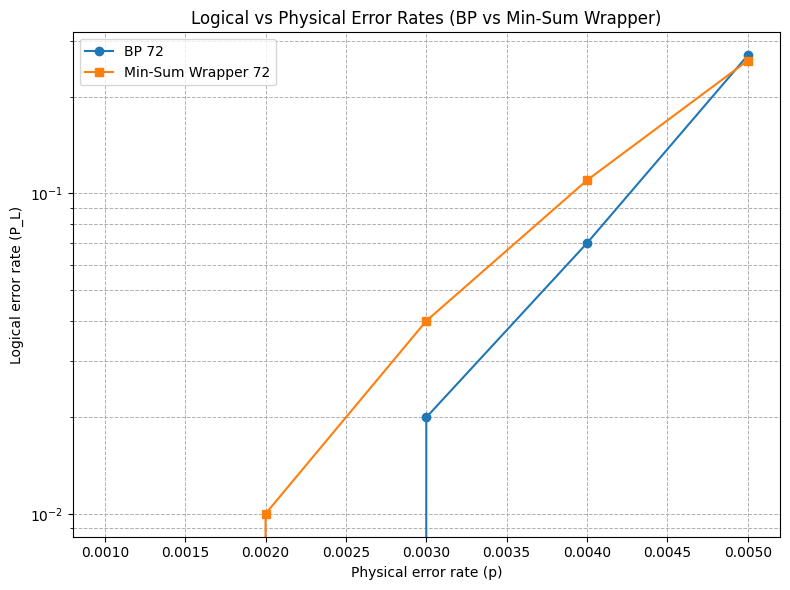

In [2]:
import matplotlib.pyplot as plt

# Plot logical error rates vs physical error rates
plt.figure(figsize=(8,6))

for codeConfig in codesConfig:
    plt.plot(ps, PlsBP[codeConfig], marker="o", label=f"BP {codeConfig}")
    plt.plot(ps, PlsBPOSD[codeConfig], marker="s", label=f"Min-Sum Wrapper {codeConfig}")

plt.yscale("log")   # eje Y logarítmico
plt.xscale("linear") # el eje X lo dejamos lineal
plt.xlabel("Physical error rate (p)")
plt.ylabel("Logical error rate (P_L)")
plt.title("Logical vs Physical Error Rates (BP vs Min-Sum Wrapper)")
plt.grid(True, which="both", ls="--", lw=0.7)
plt.legend()
plt.tight_layout()

# Guardar en PNG
plt.savefig("logical_vs_physical.png", dpi=300)